In [27]:
# Imports
import time
import math
import sys
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
from PIL import Image
from scipy import ndimage
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from fc_utils import *
from cnn_utils import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig, classes = load_dataset()
# classes = 6
# train_labels = np.squeeze(train_labels_orig)
# train_labels_old = train_labels
# train_labels = one_hot_label(classes, train_labels_old)
# eval_labels = np.squeeze(eval_labels_orig)
# eval_labels_old = eval_labels
# eval_labels = one_hot_label(classes, eval_labels_old)
# # Flatten the training and test images
# train_data = train_data_orig.reshape(train_data_orig.shape[0], -1).T
# eval_data = eval_data_orig.reshape(eval_data_orig.shape[0], -1).T
# # Normalize image vectors
# train_data = train_data/255.
# eval_data = eval_data/255.
# features = train_data.shape[0]
# print(train_data.shape)

In [29]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
classes = 10
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels = one_hot_label(classes, train_labels)
eval_data = mnist.test.images # Returns np.array
eval_labels_old = np.asarray(mnist.test.labels, dtype=np.int32)
eval_labels = one_hot_label(classes, eval_labels_old)
features = train_data.shape[0]

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(10000, 784)


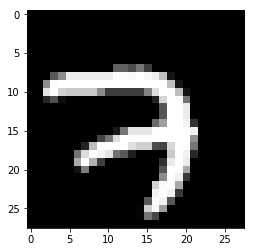

In [30]:
print(train_data.shape)
print(eval_data.shape)
# Input Layer
input_layer = train_data.reshape(55000, 28,28,1)
eval_data = eval_data.reshape(10000, 28, 28, 1)
plt.imshow(input_layer[0,:,:,0])

## Plan
**input layer:** mx28x28x1

**conv layer1 + Relu:** mx28x28x32

**pool layer1:** mx14x14x32

**conv layer2 + Relu:** mx14x14x64

**pool layer2:** mx7x7x64

**flatten:** mx3136

**fc layer1:** mx1024

**output layer:** mx10

**softmax:** mx10

in im2Col_indices, x_padded is:
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0

in im2Col_indices, x_padded is:
[[[[0.00000000e+00 0.00000000e+00 8.48129093e-05 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.32668236e-03 3.38634352e-04 1.77130019e-04 ... 7.70957896e-04
    3.91334396e-04 0.00000000e+00]
   [2.10812735e-03 3.51539434e-03 6.00351247e-03 ... 0.00000000e+00
    1.22694554e-03 2.46025428e-04]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.61033016e-03
    3.22599208e-03 8.49939257e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.23514942e-03
    1.45808045e-03 1.31387215e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.15365980e-03
    8.16089133e-04 2.80503183e-04]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [2.97472628e-05 0.00000000e+00 0.00000000e+00 ... 6.74663889e-04
    1.64574058e-04 1.37606671e-06]
   ...
   [0.00000000e+00 1.82

in im2Col_indices, x_padded is:
[[[[0.00497137 0.00490344 0.00536778 ... 0.00515323 0.005098
    0.00509542]
   [0.00485403 0.00479182 0.00555922 ... 0.0048994  0.00495863
    0.00496245]
   [0.00451772 0.00432778 0.00518057 ... 0.00444303 0.00461143
    0.00476259]
   ...
   [0.00451772 0.00432778 0.00442965 ... 0.00811314 0.00489889
    0.00476259]
   [0.00437694 0.00422085 0.00419123 ... 0.00504435 0.00452557
    0.00465807]
   [0.00423504 0.0041967  0.0041955  ... 0.00436631 0.00443599
    0.00471983]]]


 [[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.     

in im2Col_indices, x_padded is:
[[[[1.90942179e-02 2.00815252e-02 2.27025827e-02 ... 2.10901988e-02
    2.00640522e-02 2.02014749e-02]
   [1.97520346e-02 2.20486647e-02 2.50156369e-02 ... 2.24561366e-02
    2.12984797e-02 1.89868554e-02]
   [2.08355211e-02 2.51567102e-02 2.61596707e-02 ... 2.88537829e-02
    2.76821177e-02 2.12621420e-02]
   ...
   [1.41476736e-02 1.15696151e-02 9.10721333e-03 ... 2.39486144e-02
    2.04695334e-02 1.91377304e-02]
   [1.71424351e-02 1.18437256e-02 9.51487773e-03 ... 1.74877382e-02
    1.82168193e-02 1.89605828e-02]
   [1.74748667e-02 1.66078641e-02 1.31790471e-02 ... 1.53043063e-02
    1.79415049e-02 1.86820416e-02]]]


 [[[1.75980509e-03 7.23851583e-04 7.21115164e-04 ... 0.00000000e+00
    7.72484643e-05 6.31658277e-04]
   [1.20816074e-03 1.36137337e-03 2.88308950e-03 ... 0.00000000e+00
    9.57613705e-04 3.42027116e-03]
   [5.48290795e-04 3.85345985e-03 2.16255488e-03 ... 0.00000000e+00
    0.00000000e+00 7.28370881e-04]
   ...
   [2.98505889e-03 4.50

in im2Col_indices, x_padded is:
[[[[1.49001203e-02 1.49790023e-02 1.61879762e-02 ... 1.86191459e-02
    1.69649655e-02 1.66617959e-02]
   [1.45923588e-02 1.56985110e-02 1.82719643e-02 ... 1.92112819e-02
    1.66805510e-02 1.70594052e-02]
   [1.40033747e-02 1.50127907e-02 1.93636355e-02 ... 2.49167502e-02
    2.32074350e-02 1.90797451e-02]
   ...
   [1.40033747e-02 1.53957950e-02 1.53331953e-02 ... 1.46878663e-02
    1.50713630e-02 1.48881365e-02]
   [1.32323154e-02 1.19050551e-02 4.31262485e-03 ... 1.34877421e-02
    1.43549635e-02 1.42552660e-02]
   [1.25498410e-02 1.05446166e-02 2.29067060e-03 ... 1.28777875e-02
    1.36795678e-02 1.41877424e-02]]]


 [[[1.52547181e-03 1.33695815e-03 1.52878336e-03 ... 0.00000000e+00
    0.00000000e+00 9.64954126e-04]
   [2.07582677e-03 1.23501047e-03 1.29575702e-03 ... 1.44694177e-04
    3.90362395e-03 4.90316317e-03]
   [1.67830977e-03 9.62290919e-04 3.09302224e-03 ... 1.17692807e-03
    2.37920423e-03 2.66299992e-03]
   ...
   [1.67830977e-03 1.73

in im2Col_indices, x_padded is:
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.34174695e-03 ... 2.34174695e-03
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.0000

in im2Col_indices, x_padded is:
[[[[0.01217975 0.01242496 0.0149506  ... 0.01447051 0.01325783
    0.01244277]
   [0.01189682 0.01235065 0.01665566 ... 0.01438001 0.01267952
    0.01181062]
   [0.01096443 0.01185679 0.01837167 ... 0.01283065 0.01214919
    0.01168089]
   ...
   [0.01096443 0.00969366 0.00418934 ... 0.01622207 0.01324995
    0.01134835]
   [0.0099147  0.00956462 0.0069163  ... 0.00819506 0.01100263
    0.01096014]
   [0.00895366 0.00901135 0.00863357 ... 0.00900658 0.01018284
    0.01070102]]]


 [[[0.00091899 0.00074606 0.00047773 ... 0.00185735 0.00086493
    0.00014669]
   [0.00157489 0.0012726  0.00092643 ... 0.00247527 0.00138728
    0.00048629]
   [0.00090165 0.00015432 0.00032119 ... 0.00163196 0.00041435
    0.        ]
   ...
   [0.00090165 0.00072404 0.00215726 ... 0.0034853  0.00166394
    0.        ]
   [0.00053504 0.00105063 0.00169087 ... 0.00238413 0.00117041
    0.00062446]
   [0.00062181 0.00027644 0.00044613 ... 0.         0.
    0.        ]]]


 [[[0.

in im2Col_indices, x_padded is:
[[[[0.02724077 0.02767566 0.02965135 ... 0.02965135 0.02891182
    0.02810894]
   [0.03088835 0.0306315  0.03299795 ... 0.03126959 0.0295728
    0.0279443 ]
   [0.04189103 0.04542241 0.05397392 ... 0.03708369 0.03078952
    0.02960826]
   ...
   [0.02561133 0.02594297 0.02758335 ... 0.05093952 0.03924412
    0.02785227]
   [0.02433217 0.02454701 0.02540732 ... 0.04332485 0.03495621
    0.02666133]
   [0.02302142 0.0233915  0.02391835 ... 0.03610373 0.02904543
    0.02580202]]]


 [[[0.00412143 0.0042571  0.00489991 ... 0.00489991 0.00438181
    0.00331101]
   [0.00310681 0.         0.         ... 0.00593605 0.00563782
    0.00417665]
   [0.00433151 0.         0.         ... 0.00826257 0.00917401
    0.00485767]
   ...
   [0.00407404 0.00416683 0.00499413 ... 0.02335461 0.01313021
    0.0041411 ]
   [0.00350766 0.00439183 0.00468553 ... 0.01890879 0.00885515
    0.0038699 ]
   [0.00340078 0.00320762 0.00330172 ... 0.01099262 0.00485058
    0.00222586]]]



in im2Col_indices, x_padded is:
[[[[0.02801412 0.03097776 0.03103717 ... 0.02591096 0.02516041
    0.02405364]
   [0.02899918 0.03545316 0.0374255  ... 0.02647923 0.02559122
    0.02322933]
   [0.02576144 0.029427   0.03494246 ... 0.03129901 0.02766317
    0.02320084]
   ...
   [0.02005344 0.01827181 0.01660927 ... 0.04757284 0.03827971
    0.02987779]
   [0.01882151 0.01918301 0.02054443 ... 0.03370968 0.02921497
    0.02400879]
   [0.01726909 0.01779537 0.01856235 ... 0.02028433 0.0210802
    0.02068602]]]


 [[[0.00041587 0.00326444 0.         ... 0.0017667  0.0010467
    0.        ]
   [0.00101917 0.00428564 0.00070285 ... 0.0054529  0.002799
    0.00048093]
   [0.         0.00393495 0.00696911 ... 0.01004901 0.00376729
    0.        ]
   ...
   [0.         0.00028452 0.00055755 ... 0.02086696 0.01003637
    0.00349759]
   [0.         0.00051961 0.00098284 ... 0.0135052  0.00568762
    0.00200601]
   [0.         0.         0.         ... 0.00619855 0.00231592
    0.00015024]]]


 [

in im2Col_indices, x_padded is:
[[[[0.03101476 0.03191167 0.03586231 ... 0.04965417 0.04227662
    0.0356788 ]
   [0.03019142 0.03281374 0.04066871 ... 0.05962735 0.04949379
    0.03660455]
   [0.02808865 0.0325999  0.04596885 ... 0.06735678 0.04779547
    0.03576565]
   ...
   [0.02808865 0.02763078 0.02394913 ... 0.03521613 0.03293341
    0.03267988]
   [0.02592067 0.02601682 0.01942081 ... 0.02945485 0.03096032
    0.03115071]
   [0.02355734 0.02437416 0.01854013 ... 0.02570394 0.02826062
    0.02965317]]]


 [[[0.01039134 0.01089382 0.01214686 ... 0.01970526 0.021201
    0.01183254]
   [0.01095408 0.01150134 0.01338262 ... 0.03048064 0.02236343
    0.01282948]
   [0.00963378 0.01111133 0.01625999 ... 0.03672895 0.02069412
    0.01291564]
   ...
   [0.00963378 0.01055415 0.01471951 ... 0.0161426  0.01193461
    0.01074767]
   [0.00893943 0.01098866 0.01249443 ... 0.01382787 0.01167834
    0.01089786]
   [0.00841236 0.00890091 0.00916148 ... 0.00993324 0.00877513
    0.00845086]]]




in im2Col_indices, x_padded is:
[[[[3.85168017e-02 4.02610352e-02 4.60707764e-02 ... 6.73161160e-02
    5.15382474e-02 4.51172277e-02]
   [3.73466869e-02 3.98765771e-02 4.47919599e-02 ... 9.91978851e-02
    6.70500359e-02 5.09783725e-02]
   [3.48132440e-02 3.73417361e-02 4.33102823e-02 ... 1.35159163e-01
    8.80477969e-02 5.74220847e-02]
   ...
   [2.98910323e-02 1.72306855e-02 9.93091969e-03 ... 4.33093988e-02
    4.31539014e-02 4.28645748e-02]
   [2.02328934e-02 1.21975330e-04 0.00000000e+00 ... 3.82714498e-02
    4.02863739e-02 4.05835253e-02]
   [1.72230673e-02 1.73608927e-03 0.00000000e+00 ... 3.30035698e-02
    3.59986268e-02 3.77489027e-02]]]


 [[[1.39716049e-02 1.49561018e-02 1.68720807e-02 ... 2.87503484e-02
    2.45677122e-02 1.50952683e-02]
   [1.44673828e-02 1.58327889e-02 1.90426979e-02 ... 4.78744156e-02
    4.01128009e-02 2.24443856e-02]
   [1.27213576e-02 1.47662437e-02 1.78458925e-02 ... 6.23828982e-02
    4.99761613e-02 2.74200885e-02]
   ...
   [1.41831633e-02 2.44

in im2Col_indices, x_padded is:
[[[[0.03830586 0.0469326  0.05647059 ... 0.04527919 0.03999528
    0.03830465]
   [0.03876581 0.05699676 0.07759175 ... 0.05042975 0.0423549
    0.03781523]
   [0.03637686 0.05290246 0.07962387 ... 0.06710667 0.04701449
    0.03800071]
   ...
   [0.03023074 0.0422762  0.0341939  ... 0.02818748 0.03400257
    0.03705206]
   [0.02640447 0.02132401 0.         ... 0.03136397 0.03496286
    0.03566937]
   [0.02184929 0.00746562 0.         ... 0.02656515 0.03012191
    0.03252835]]]


 [[[0.02067607 0.02372927 0.02779683 ... 0.02642546 0.02230324
    0.01871337]
   [0.02337038 0.0344094  0.04435602 ... 0.03922752 0.02701007
    0.02095341]
   [0.02190242 0.03449397 0.04993692 ... 0.05275813 0.03188362
    0.02138424]
   ...
   [0.01892048 0.02985168 0.04496933 ... 0.04105785 0.03634895
    0.02925462]
   [0.01718047 0.02429004 0.0334317  ... 0.02568969 0.02429865
    0.02197618]
   [0.01488118 0.0180279  0.01987769 ... 0.01799388 0.01690649
    0.01686021]]]



in im2Col_indices, x_padded is:
[[[[0.05267265 0.05591655 0.06645099 ... 0.06382257 0.05958422
    0.05786304]
   [0.05108041 0.05555488 0.07298445 ... 0.06475641 0.06106052
    0.05895357]
   [0.04771824 0.05402208 0.08412661 ... 0.07871869 0.06812534
    0.0624264 ]
   ...
   [0.04304479 0.03499049 0.0324742  ... 0.09538867 0.06442723
    0.05963722]
   [0.04284633 0.04556696 0.05000133 ... 0.06563515 0.05669817
    0.05602033]
   [0.0384614  0.04206911 0.04546477 ... 0.04543652 0.04883442
    0.05157717]]]


 [[[0.02256146 0.02459556 0.02827293 ... 0.02758435 0.02508602
    0.02143215]
   [0.02278545 0.02554106 0.03345958 ... 0.03061197 0.02827751
    0.02453305]
   [0.01985038 0.02396661 0.0378714  ... 0.03269192 0.03421129
    0.0271451 ]
   ...
   [0.01854507 0.01837568 0.02046073 ... 0.0672403  0.03274156
    0.02504044]
   [0.01772953 0.02204487 0.02463573 ... 0.0482324  0.02848722
    0.02451001]
   [0.01559408 0.0178653  0.02005856 ... 0.03268532 0.02044983
    0.01971745]]]


in im2Col_indices, x_padded is:
[[[[0.05198533 0.05644373 0.07732777 ... 0.07814009 0.06356473
    0.06047867]
   [0.04960255 0.05758795 0.09211691 ... 0.101118   0.07140716
    0.061561  ]
   [0.0454788  0.05928666 0.10264199 ... 0.14128158 0.08474577
    0.0629498 ]
   ...
   [0.0454788  0.04889612 0.03024339 ... 0.12628663 0.07328807
    0.06216223]
   [0.0413575  0.04628279 0.03159516 ... 0.07808743 0.05712406
    0.05833419]
   [0.0365352  0.04079129 0.03506528 ... 0.04535638 0.04776298
    0.05304483]]]


 [[[0.02924075 0.03220719 0.04060319 ... 0.04773521 0.034389
    0.0281196 ]
   [0.02986524 0.03471331 0.05661399 ... 0.07228812 0.04459399
    0.03177304]
   [0.02637462 0.03508428 0.07006361 ... 0.09326385 0.05601536
    0.03349571]
   ...
   [0.02637462 0.03076638 0.03625339 ... 0.11109933 0.05907322
    0.0342194 ]
   [0.02388977 0.03006493 0.02989136 ... 0.07985704 0.0467939
    0.03242609]
   [0.02083365 0.02385762 0.02429018 ... 0.05160237 0.0299907
    0.02628737]]]


 [

in im2Col_indices, x_padded is:
[[[[0.06027168 0.06680433 0.08543288 ... 0.09496121 0.0745066
    0.07316514]
   [0.05778495 0.06701832 0.09958769 ... 0.11296692 0.0769471
    0.07598102]
   [0.05304899 0.06517273 0.11571544 ... 0.12047914 0.07658163
    0.07771248]
   ...
   [0.05304899 0.06317867 0.06893144 ... 0.22128654 0.13761408
    0.08639824]
   [0.04822976 0.05744433 0.0660802  ... 0.12143706 0.085821
    0.07143051]
   [0.04188631 0.0489028  0.05468769 ... 0.0584991  0.05972106
    0.06298348]]]


 [[[0.02395924 0.02687492 0.03354765 ... 0.04327968 0.02757846
    0.02278844]
   [0.0238281  0.028153   0.044564   ... 0.05611848 0.03081606
    0.02703119]
   [0.01815204 0.02464586 0.05477542 ... 0.05790374 0.0290958
    0.0284247 ]
   ...
   [0.01815204 0.02396403 0.02799754 ... 0.15884908 0.09630313
    0.04681855]
   [0.0162539  0.02383694 0.02892771 ... 0.10913416 0.07232998
    0.03925058]
   [0.01256426 0.01627918 0.0202571  ... 0.05638097 0.03445055
    0.02418085]]]


 [[

in im2Col_indices, x_padded is:
[[[[0.06332694 0.07167046 0.08785683 ... 0.09143022 0.08176559
    0.08086075]
   [0.05941601 0.07148156 0.09150002 ... 0.09073024 0.08550637
    0.08536927]
   [0.0537527  0.06754299 0.09698518 ... 0.08715667 0.08580607
    0.08829344]
   ...
   [0.0537527  0.06754299 0.07815714 ... 0.14834489 0.09379926
    0.08758551]
   [0.04794383 0.06085768 0.07167012 ... 0.08349466 0.07701113
    0.08194989]
   [0.04090145 0.05076556 0.05833781 ... 0.05794853 0.06516641
    0.07132721]]]


 [[[0.03863958 0.04445949 0.053262   ... 0.05563553 0.04758533
    0.04080647]
   [0.03987314 0.04840313 0.06298432 ... 0.06358819 0.05468436
    0.04847178]
   [0.03365371 0.04484549 0.06652421 ... 0.06209016 0.05511744
    0.05247954]
   ...
   [0.03365371 0.04484549 0.05749622 ... 0.15609772 0.09220251
    0.05535024]
   [0.03057727 0.04312856 0.05341773 ... 0.10705971 0.06482677
    0.05061824]
   [0.02413909 0.03142689 0.03931906 ... 0.05315325 0.04055381
    0.03957684]]]


in im2Col_indices, x_padded is:
[[[[0.07562463 0.09164278 0.13304935 ... 0.16503928 0.11403888
    0.09589887]
   [0.07249522 0.10968075 0.18019135 ... 0.2446145  0.14520882
    0.10225585]
   [0.06669901 0.12546936 0.21211089 ... 0.31021401 0.17206453
    0.1053537 ]
   ...
   [0.01970404 0.         0.         ... 0.36319459 0.29787796
    0.17653954]
   [0.02654178 0.         0.         ... 0.22960708 0.17337934
    0.10991355]
   [0.03862943 0.01428789 0.         ... 0.10823822 0.08712518
    0.07996398]]]


 [[[0.05011779 0.0607443  0.0844705  ... 0.12437642 0.07701185
    0.05302346]
   [0.05228549 0.07656605 0.13851322 ... 0.18496137 0.10707944
    0.06292956]
   [0.04540301 0.09084922 0.18152822 ... 0.2386451  0.12687772
    0.06862114]
   ...
   [0.03637364 0.03894749 0.06849102 ... 0.34219856 0.30330753
    0.18790004]
   [0.02753862 0.02637927 0.03371849 ... 0.26090835 0.20931311
    0.13384895]
   [0.02532789 0.01908787 0.01633329 ... 0.16599155 0.12011274
    0.07327779]]]


in im2Col_indices, x_padded is:
[[[[0.07525101 0.09644135 0.12548657 ... 0.19394743 0.14584114
    0.11151958]
   [0.070673   0.11827418 0.16755703 ... 0.33958272 0.22623278
    0.1341015 ]
   [0.06578654 0.14180069 0.20376247 ... 0.48488108 0.29905278
    0.14717223]
   ...
   [0.06230074 0.08085842 0.08946657 ... 0.09796169 0.10316608
    0.10679501]
   [0.05524216 0.07224969 0.07095147 ... 0.08542732 0.09351976
    0.09770159]
   [0.04537984 0.05783564 0.05049245 ... 0.06541213 0.07539502
    0.08196535]]]


 [[[0.05175516 0.06738694 0.09017814 ... 0.1326651  0.11268743
    0.07018904]
   [0.05335113 0.09063645 0.14689099 ... 0.25508211 0.18795335
    0.09335291]
   [0.04624166 0.11616735 0.20406649 ... 0.37463404 0.241097
    0.10558495]
   ...
   [0.04408299 0.06224527 0.08581784 ... 0.10061604 0.0778761
    0.07463076]
   [0.03829193 0.05703622 0.06916228 ... 0.07667492 0.07013358
    0.06899371]
   [0.02815903 0.03941916 0.04332719 ... 0.05090101 0.05003156
    0.05286414]]]


 

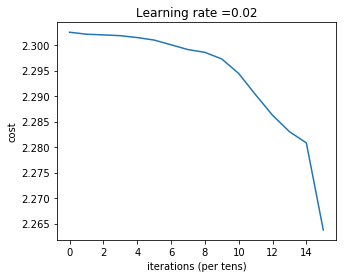

In [98]:
# training model
filter_dims = [(5,5,1,32),(5,5,32,64)]
layers_dims = [3136, 1024, classes] #  2-layer model
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:4096], train_labels[0:4096], filter_dims, layers_dims, batch_size = 256, learning_rate = 0.02, num_iterations = 1, print_cost = True)

In [99]:
#further training on the same model 
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:4096], train_labels[:,0:4096], filter_dims, layers_dims, batch_size = 256, learning_rate = 0.002, num_iterations = 1, parameters = parameters, parameters_conv = parameters_conv, print_cost = True)



Cost after iteration 0, batch 0: 2.246672


KeyboardInterrupt: 

In [32]:
train_labels.shape

(10, 55000)

In [89]:
#eval_cnn_model(input_layer[0:4096], train_labels[:,0:4096], parameters, parameters_conv)

eval_cnn_model(eval_data[0+5000:512+5000], eval_labels[:,5000:512+5000], parameters, parameters_conv)
parameters

Accuracy: 0.955078125


{'W1': array([[ 2.00000910e-02, -1.07224824e-10,  0.00000000e+00, ...,
         -5.39657237e-08, -6.03859846e-08,  9.99999968e-03],
        [ 2.00000000e-02,  0.00000000e+00,  0.00000000e+00, ...,
          2.00000000e-02, -1.00000000e-02,  0.00000000e+00],
        [-8.20010015e-07, -1.99999986e-02,  9.99999963e-03, ...,
         -2.00000950e-02, -3.79355850e-07, -9.99977648e-03],
        ...,
        [-1.43837875e-07, -1.00000027e-02, -1.47155572e-09, ...,
         -2.81100621e-07, -1.00001693e-02, -2.15166939e-08],
        [-1.00001929e-02, -1.29327550e-09,  2.03386487e-09, ...,
         -2.20504063e-07, -2.00000965e-02, -1.00003595e-02],
        [-1.00000752e-02,  9.99999992e-03, -1.00000000e-02, ...,
          1.00000094e-02, -1.00000570e-02, -9.99997099e-03]]),
 'b1': array([[-2.09390810e-07],
        [ 0.00000000e+00],
        [-1.06249673e-06],
        ...,
        [-1.85838435e-07],
        [-2.01117842e-08],
        [-5.04677218e-08]]),
 'W2': array([[-7.22197143e-06, -1.00000

predictions: 4
actual value: 4


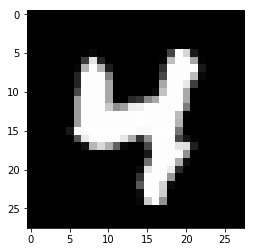

In [74]:
image_num = 85
predict_cnn(eval_data[image_num:image_num+1],parameters, parameters_conv)
print("actual value: " + str(eval_labels_old[image_num]))
data = mnist.test.images[image_num].reshape(28,28)
plt.imshow(data)

[ 0.16  0.03  0.05 ...  0.05  0.21 -0.05]


/Users/samshen/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


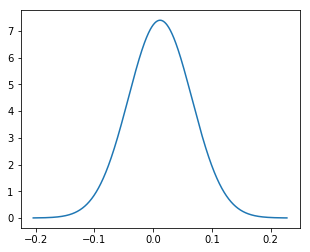

one std is 0.05394559397882455


In [78]:
np.set_printoptions(threshold=10)
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['b1'].reshape(-1), 
                     parameters_conv['W3'].reshape(-1), parameters_conv['b3'].reshape(-1),
                     conv_grads["dW3"].reshape(-1), conv_grads["db3"].reshape(-1),
                     conv_grads["dW1"].reshape(-1), conv_grads["db1"].reshape(-1)))
#out = out.reshape(-1,1)
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [97]:
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['W3'].reshape(-1),
                      parameters_conv['b1'].reshape(-1),parameters_conv['b3'].reshape(-1),
                      conv_grads['dW1'].reshape(-1), conv_grads['dW3'].reshape(-1),
                      conv_grads['db1'].reshape(-1),conv_grads['db3'].reshape(-1)))
out = out.reshape(-1,8)
np.savetxt("parameters.csv", out, delimiter=",")

array([[ 0.04,  0.58, -1.1 ],
       [ 1.14,  0.9 ,  0.5 ],
       [ 0.9 , -0.68, -0.12]])

In [82]:
def round8(p):
    for k,v in p.items():
        p[k] = np.around(v, decimals=2)
    return p

In [86]:
conv_grads = round8(conv_grads)
grads = round8(grads)

In [85]:
conv_grads

{'dW3': array([[[[ 0.08,  0.01, -0.15, ..., -0.01,  0.03, -0.01],
          [ 0.  ,  0.  ,  0.01, ...,  0.01,  0.  , -0.01],
          [ 0.11,  0.03, -0.29, ..., -0.04,  0.2 ,  0.01],
          ...,
          [ 0.18,  0.05, -0.52, ..., -0.08,  0.35, -0.03],
          [-0.01,  0.  , -0.01, ..., -0.  ,  0.01,  0.  ],
          [-0.  , -0.  , -0.01, ..., -0.01, -0.  ,  0.  ]],
 
         [[ 0.03,  0.02, -0.16, ..., -0.01,  0.13, -0.  ],
          [ 0.  , -0.  , -0.  , ...,  0.  ,  0.  , -0.01],
          [ 0.12,  0.01, -0.29, ..., -0.03,  0.27,  0.01],
          ...,
          [ 0.2 ,  0.05, -0.45, ..., -0.04,  0.47, -0.05],
          [ 0.  ,  0.  , -0.01, ..., -0.  , -0.  ,  0.  ],
          [ 0.01, -0.  , -0.01, ..., -0.01, -0.  ,  0.  ]],
 
         [[ 0.04,  0.01, -0.16, ..., -0.02,  0.13,  0.04],
          [ 0.  ,  0.01, -0.  , ...,  0.  ,  0.01, -0.  ],
          [ 0.12,  0.01, -0.07, ...,  0.06,  0.21, -0.06],
          ...,
          [ 0.17,  0.01, -0.1 , ...,  0.14,  0.35, -0.12]